# Error Plot JCPexample3

## Steady Stokes Flow in Sphere

## Import stuff

In [5]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import DRLPDE_nn
import DRLPDE_param_solver
import DRLPDE_functions.DefineDomain
import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

## Error Plot

In [6]:
## Load Trained model
nn_param = {'depth': 60,
                'width': 4,
                'x_dim':3,
                'is_unsteady':False,
                'output_dim':3
                }

loadmodel = 'JCPexample3'
Velocity_NN = DRLPDE_nn.IncompressibleNN
model = Velocity_NN(**nn_param)
model.load_state_dict(torch.load("savedmodels/" + loadmodel + ".pt"))

imagefilename = 'Error_Plot' + loadmodel
imagesfolder = "images/"

### Setup Variables and Calculate Error

In [7]:
dim_space = 3
dim_full = dim_space
    
mu = 1
L = 1  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 1
dim = 3

numpts_r = 5
numpts_th = 30
numpts_phi = 13 ### 7k - 1 for integer k
numpts_time = 20

### Analytic Solution
r,th, phi = torch.meshgrid([torch.linspace(0,1, numpts_r),
                            torch.linspace(0,2*math.pi, numpts_th),
                            torch.linspace(0,math.pi, numpts_phi)])

x1g = r*torch.cos(th)*torch.sin(phi)
x2g = r*torch.sin(th)*torch.sin(phi)
x3g = r*torch.cos(phi)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1), x3g.reshape(-1)], dim=-1).requires_grad_(True)

integral_factor = (2*math.pi)*(math.pi)*r.numpy()*torch.sin(phi).numpy()/(numpts_r-1)/(numpts_th-1)

u1_true = - v0*r*torch.sin(th)*torch.sin(phi)
u2_true = v0*r*torch.cos(th)*torch.sin(phi)
u3_true = 0*r
 
u_true = torch.stack([u1_true, u2_true, u3_true], dim=-1)

ug = model(xg).reshape([numpts_r, numpts_th, numpts_phi, 3]).detach().cpu().numpy()

u1_approx = ug[:,:,:,0]
u2_approx = ug[:,:,:,1]
u3_approx = ug[:,:,:,2]

x1plot = x1g.numpy()
x2plot = x2g.numpy()
x3plot = x3g.numpy()

u1_plot = u1_true.numpy()
u2_plot = u2_true.numpy()
u3_plot = u3_true.numpy()

L2_error = np.sqrt( np.sum( ((u1_approx - u1_plot)**2)*integral_factor ) \
                   + np.sum( ((u2_approx - u2_plot)**2)*integral_factor ) \
                   + np.sum( ((u3_approx - u3_plot)**2)*integral_factor ))
    
Linf_error = np.max( [np.max( np.abs(u1_approx - u1_plot)) , 
                      np.max( np.abs(u2_approx - u2_plot)) ,
                      np.max( np.abs(u3_approx - u3_plot))])

L2_norm_true = np.sqrt( np.sum( ( u1_plot**2)*integral_factor ) \
                       + np.sum( ( u2_plot**2)*integral_factor ) \
                       + np.sum( ( u3_plot**2)*integral_factor ) )

Linf_norm_true = np.max( [np.max( np.abs(u1_plot)) , 
                      np.max( np.abs(u2_plot)) ,
                      np.max( np.abs(u3_plot))])

print("L2 Error = {:.5f}".format(L2_error))
print("Linf Error = {:.5f}".format(Linf_error))

print("Relative L2 Error = {:.5f}".format(L2_error/L2_norm_true))
print("Relative Linf Error = {:.5f}".format(Linf_error/Linf_norm_true))



L2 Error = 0.04985
Linf Error = 0.00934
Relative L2 Error = 0.00782
Relative Linf Error = 0.00934


### Plot

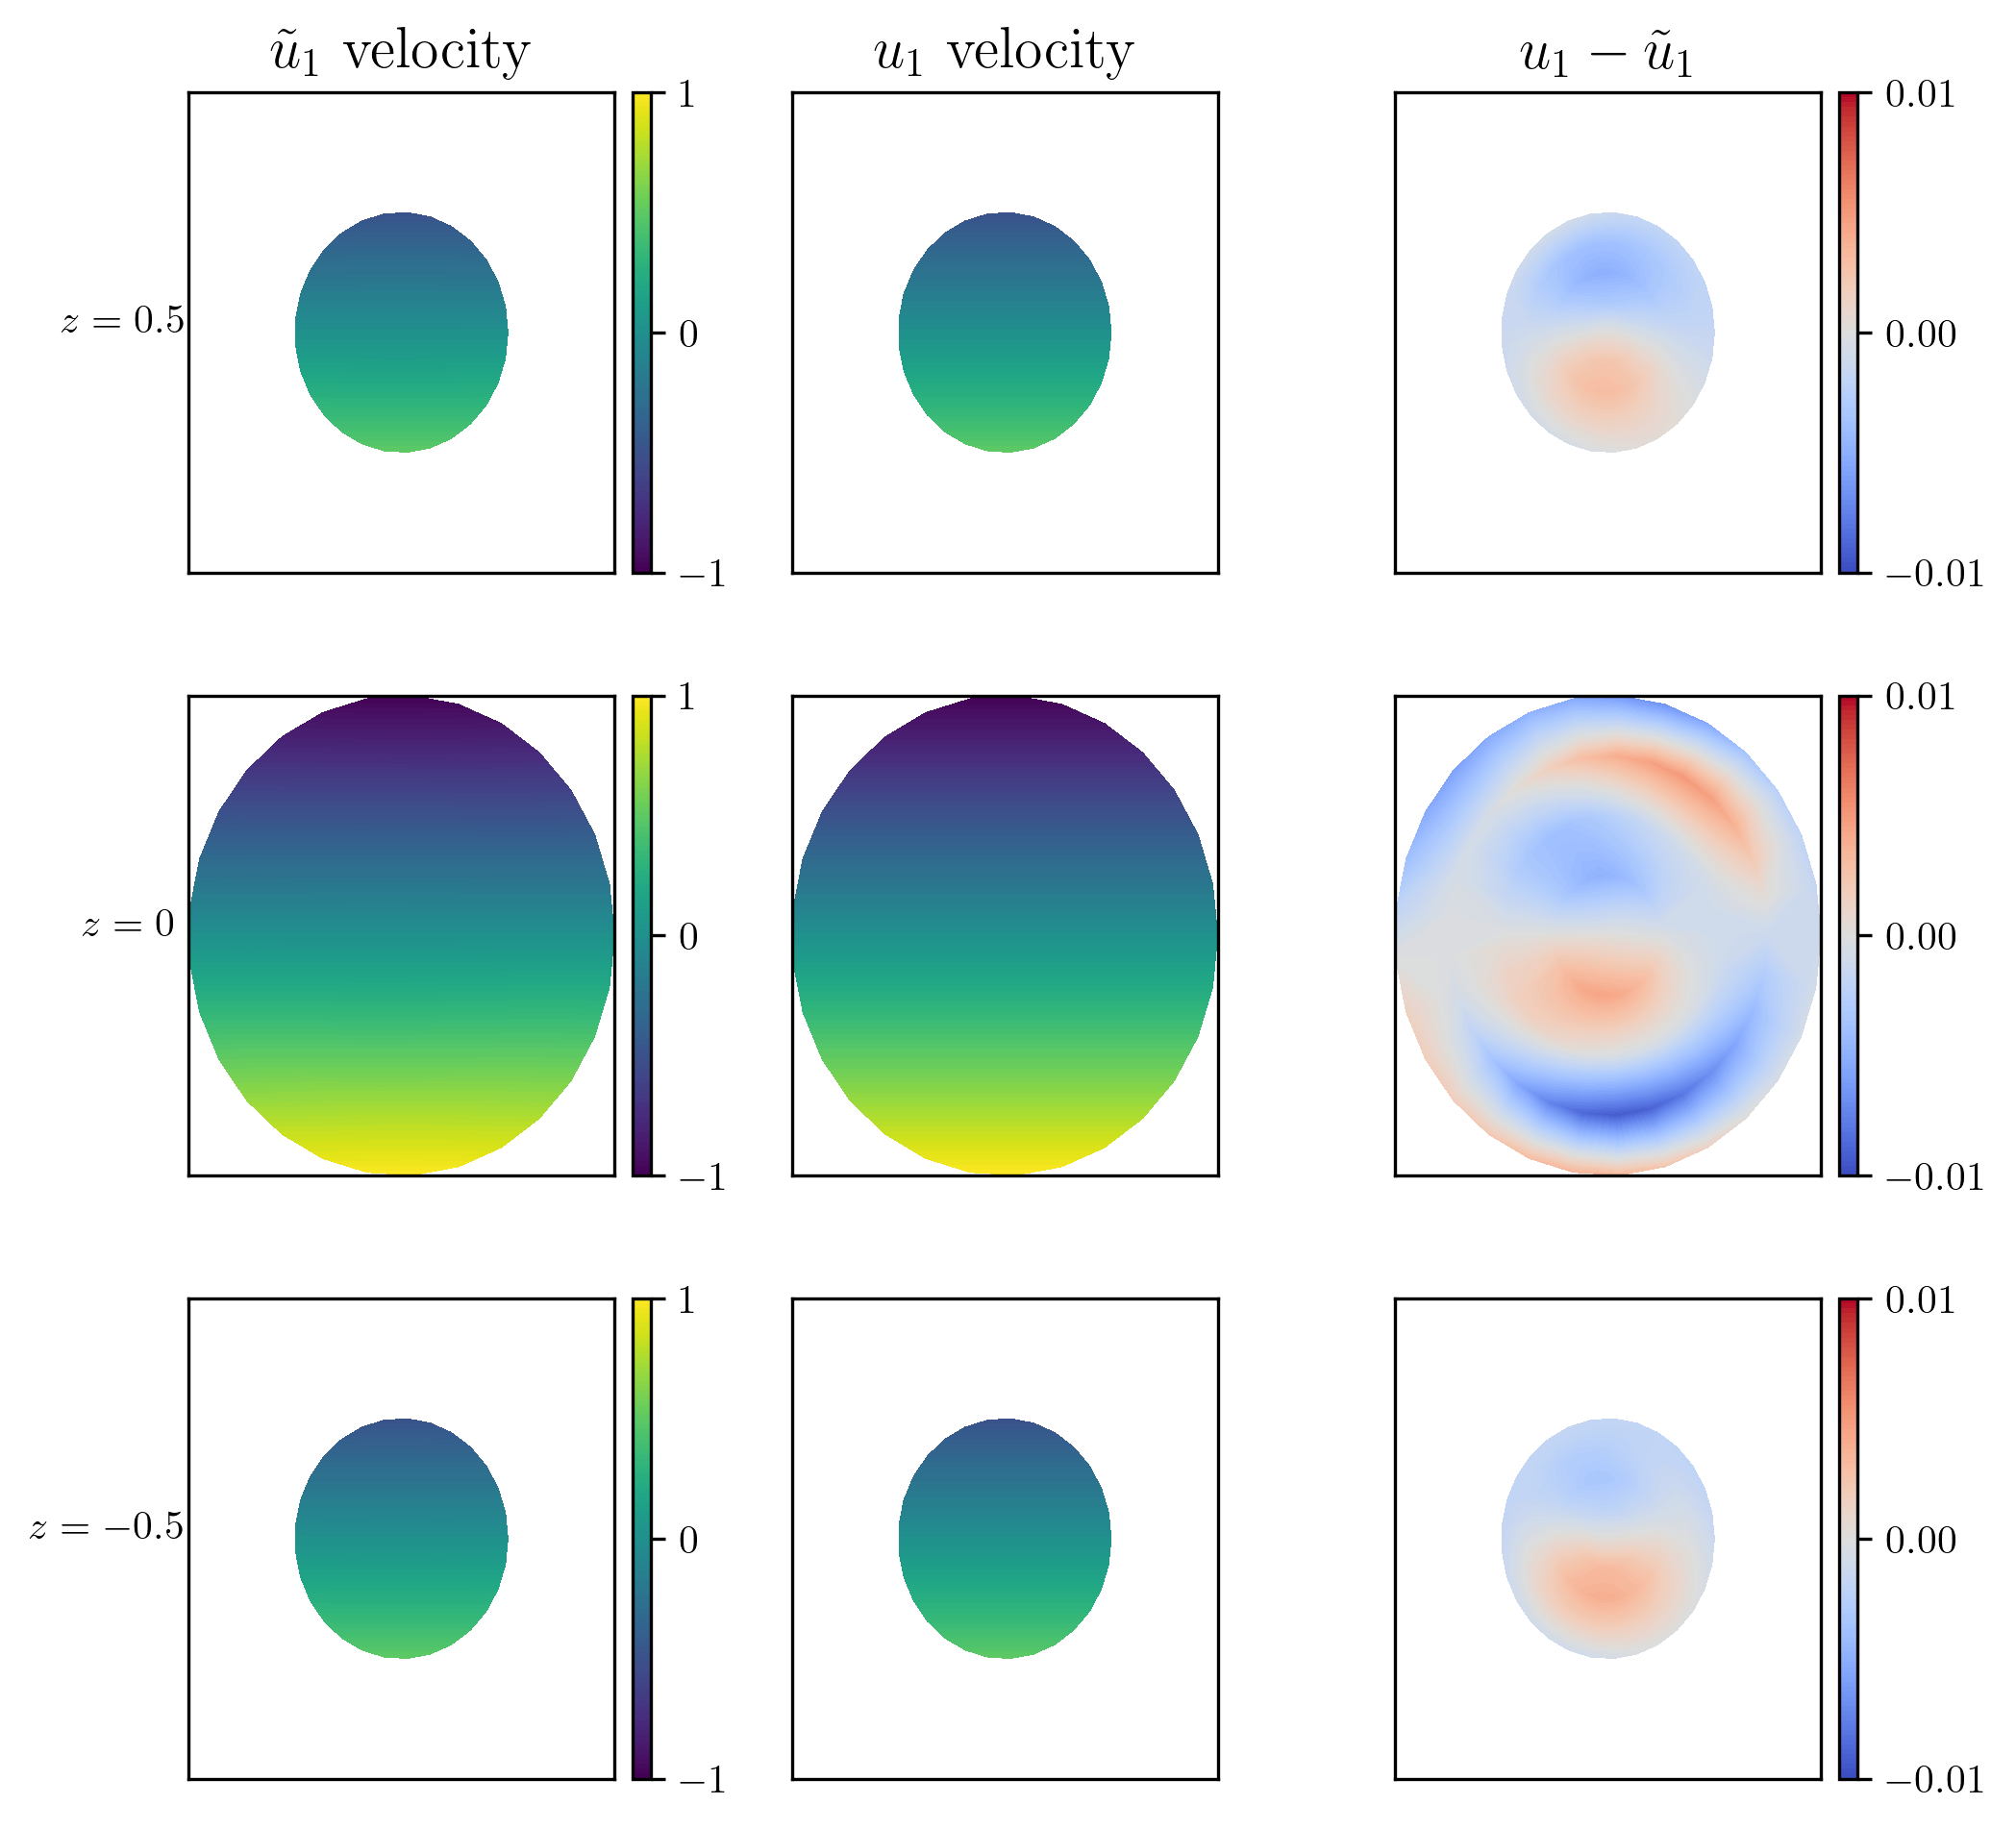

In [19]:
index1 = int( (numpts_phi-1)/6)
index2 = int( (numpts_phi-1)/2)
index3 = int( 5*(numpts_phi-1)/6)

levels_stokes = np.linspace(-1,1, 100)
levels_tick = np.linspace(-1,1,3)

error_levels = np.linspace(-0.01, 0.01, 100)
error_tick = np.linspace(-0.01, 0.01, 3)

plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[6.4, 6.4])
plt.tight_layout(pad=0.75)

## Plot 0
contour0 = ax[0,0].contourf(x1plot[:,:,index1], x2plot[:,:,index1], 
                            u1_approx[:,:,index1], levels = levels_stokes, cmap=plt.cm.viridis)

ax[0,0].set_title(r'$\tilde{u}_1$ velocity')
ax[0,0].set_xlim(-1,1)
ax[0,0].set_ylim(-1,1)

ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

ax[0,0].text(-1.6, 0, r'$z=0.5$', fontsize=10)

colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.01,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=levels_tick, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)



## Plot 1

contour1 = ax[0,1].contourf(x1plot[:,:,index1], x2plot[:,:,index1], 
                        u1_plot[:,:,index1], levels = levels_stokes, cmap=plt.cm.viridis)
ax[0,1].set_title(r'$u_1$ velocity')
ax[0,1].set_xlim(-1,1)
ax[0,1].set_ylim(-1,1)

ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour2 = ax[0,2].contourf(x1plot[:,:,index1], x2plot[:,:,index1], 
                            u1_plot[:,:,index1] - u1_approx[:,:,index1], 
                            levels=error_levels, cmap=plt.cm.coolwarm)
ax[0,2].set_title(r'$u_1 - \tilde{u}_1$')
ax[0,2].set_xlim(-1,1)
ax[0,2].set_ylim(-1,1)

ax[0,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar2_param = fig.add_axes(
    [ax[0,2].get_position().x1 + 0.01,
     ax[0,2].get_position().y0,
     0.01,
     ax[0,2].get_position().height])
colorbar2 = plt.colorbar(contour2, ticks=error_tick, cax = colorbar2_param)
colorbar2.ax.tick_params(labelsize=10)

contour3 = ax[1,0].contourf(x1plot[:,:,index2], x2plot[:,:,index2], u1_approx[:,:,index2], 
                            levels = levels_stokes, cmap=plt.cm.viridis)

ax[1,0].set_xlim(-1,1)
ax[1,0].set_ylim(-1,1)
ax[1,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

ax[1,0].text(-1.5,
             0,
             r'$z=0$',
             fontsize=10)

colorbar3_param = fig.add_axes(
    [ax[1,0].get_position().x1 + 0.01,
     ax[1,0].get_position().y0,
     0.01,
     ax[1,0].get_position().height])
colorbar3 = plt.colorbar(contour3, ticks=levels_tick, cax = colorbar3_param)
colorbar3.ax.tick_params(labelsize=10)



contour4 = ax[1,1].contourf(x1plot[:,:,index2], x2plot[:,:,index2], u1_plot[:,:,index2], 
                            levels = levels_stokes, cmap=plt.cm.viridis)

ax[1,1].set_xlim(-1,1)
ax[1,1].set_ylim(-1,1)
ax[1,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)


contour5 = ax[1,2].contourf(x1plot[:,:,index2], x2plot[:,:,index2], 
                            u1_plot[:,:,index2] - u1_approx[:,:,index2], 
                            levels=error_levels, cmap=plt.cm.coolwarm)

ax[1,2].set_xlim(-1,1)
ax[1,2].set_ylim(-1,1)

ax[1,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar5_param = fig.add_axes(
    [ax[1,2].get_position().x1 + 0.01,
     ax[1,2].get_position().y0,
     0.01,
     ax[1,2].get_position().height])
colorbar5 = plt.colorbar(contour5, ticks=error_tick, cax = colorbar5_param)
colorbar5.ax.tick_params(labelsize=10)

contour6 = ax[2,0].contourf(x1plot[:,:,index3], x2plot[:,:,index3], u1_approx[:,:,index3], 
                            levels = levels_stokes, cmap=plt.cm.viridis)

ax[2,0].set_xlim(-1,1)
ax[2,0].set_ylim(-1,1)

ax[2,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

ax[2,0].text(-1.75,
             0,
             r'$z=-0.5$',
             fontsize=10)

colorbar6_param = fig.add_axes(
    [ax[2,0].get_position().x1 + 0.01,
     ax[2,0].get_position().y0,
     0.01,
     ax[2,0].get_position().height])
colorbar6 = plt.colorbar(contour6, ticks=levels_tick, cax = colorbar6_param)
colorbar6.ax.tick_params(labelsize=10)


contour7 = ax[2,1].contourf(x1plot[:,:,index3], x2plot[:,:,index3], u1_plot[:,:,index3],
                            levels = levels_stokes, cmap=plt.cm.viridis)

ax[2,1].set_xlim(-1,1)
ax[2,1].set_ylim(-1,1)

ax[2,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour8 = ax[2,2].contourf(x1plot[:,:,index3], x2plot[:,:,index3], 
                            u1_plot[:,:,index3] - u1_approx[:,:,index3], 
                            levels=error_levels,cmap=plt.cm.coolwarm)

ax[2,2].set_xlim(-1,1)
ax[2,2].set_ylim(-1,1)

ax[2,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar8_param = fig.add_axes(
    [ax[2,2].get_position().x1 + 0.01,
     ax[2,2].get_position().y0,
     0.01,
     ax[2,2].get_position().height])
colorbar8 = plt.colorbar(contour8, ticks=error_tick, cax = colorbar8_param)
colorbar8.ax.tick_params(labelsize=10)